# **NATURAL LANGUAGE PROCESSING:**
## **Project Title :** **Title Generation**
### -by
*   **Arkadipta De (AI20MTECH14002)**
*   **Venkatesh E (AI20MTECH14005)**
*   **Priya Bhatia (AI20MTECH14015)**

#### **Guide : Dr Maunendra Sankar Desarkar, Dr Srijith**

**Description:** Given the abstract of a technical paper, generate a suitable title for it

**Data Source Link :**[Arxiv Dataset](https://www.kaggle.com/neelshah18/arxivdataset)



*   Collection of 31000+ paper meta data.
*   This data contains all paper related to ML, CL, NER, AI and CV field publish between 1992 to 2018-Feb.

### **IMPORTING LIBRARIES :**


In [ ]:
# For using in Google Colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import random

import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

from transformers import glue_compute_metrics
from transformers import Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification

from sklearn.metrics import f1_score, accuracy_score,confusion_matrix 
from sklearn.metrics import classification_report as Report

from tqdm.notebook import tqdm

import itertools    
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print("GPU Torch Available = {}".format(torch.cuda.is_available()))
print("Torch Version = {}".format(torch.__version__))

GPU Torch Available = True
Torch Version = 1.8.1+cu101


In [ ]:
# to display the rows and columns of dataset properly 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

### **DATA LOADING :**

In [ ]:
# loading the data 
def Load_Excel_Data(path1,path2):
  """
  Input : path1 and path2 - file path of excel file of X_train and y_train
  Returns : dataframe 
  """
  df1=pd.read_excel(path1)
  df2=pd.read_excel(path2)
  df=pd.concat([df1,df2],axis=1)
  df.columns=['Abstract','Domain_Labels']
  return df 

def Get_Sampled_Dataset(df):
  vals=list(df['Domain_Labels'].value_counts())
  min_val=min(vals)
  label_1=df[df['Domain_Labels']==1]
  label_0=df[df['Domain_Labels']==0]
  df0 = label_0.sample(n=min_val,random_state=42)
  new_df=pd.concat([df0,label_1],axis=0)
  new_df=shuffle(new_df)
  return new_df

def Train_Val_Test(label,undersampling=0):
  """
  Input : label - return train, val, test data for given label 
          undersampling = 0(default - don't perform undersampling on train data), else : perform undersampling on train dataset 
  Returns : dataframe - train, val and test 
  """
  train_data = Load_Excel_Data("/content/gdrive/My Drive/Title Generation NLP/Dataset/X_train.xlsx","/content/gdrive/My Drive/Title Generation NLP/Dataset/y_train_"+label+".xlsx")
  val_data = Load_Excel_Data("/content/gdrive/My Drive/Title Generation NLP/Dataset/X_val.xlsx","/content/gdrive/My Drive/Title Generation NLP/Dataset/y_val_"+label+".xlsx")
  test_data = Load_Excel_Data("/content/gdrive/My Drive/Title Generation NLP/Dataset/X_test.xlsx","/content/gdrive/My Drive/Title Generation NLP/Dataset/y_test_"+label+".xlsx")
  if undersampling!=0:
    train_data=Get_Sampled_Dataset(train_data)
  return train_data, val_data, test_data 


**Class Label : AI**

In [ ]:
# undersampling 
train_AI, val_AI, test_AI = Train_Val_Test("AI",1)

In [ ]:
# shape of data 
print("Train Shape : ",train_AI.shape)
print("Validation Shape : ",val_AI.shape)
print("Test Shape : ",test_AI.shape)

Train Shape :  (13416, 2)
Validation Shape :  (6277, 2)
Test Shape :  (7847, 2)


### **MODEL BUILDING :**

In [ ]:
def Result_Evaluator(data_val,model):
  """
  This function evaluates the f1-score and accuracy for given data 
  Input : model - Bert Base/RoBerta Base 
  """
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []
    
  for batch in data_val:
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids':batch[0],'attention_mask': batch[1],'labels':batch[2],}

    with torch.no_grad():        
      outputs = model(**inputs)
            
    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)
    
  loss_val_avg = loss_val_total/len(data_val) 
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
            
  return loss_val_avg, predictions, true_vals

#### **Performance Measure :**

In [ ]:
def f1_score_func(preds, labels):
  """
  This function returns the f1-score for given and predicted labels 
  Input : preds - predicted label 
          labels - original label 
  Returns : F1 - Score 
  """
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

def Accuracy_Score(preds,labels):
  """
  This function returns the Accuracy-score for given and predicted labels 
  Input : preds - predicted label 
          labels - original label 
  Returns : Accuracy - Score 
  """
  preds_flat=np.argmax(preds,axis=1).flatten()
  labels_flat=labels.flatten()
  return accuracy_score(labels_flat,preds_flat)

In [ ]:
def Tag_Classifier_Modelling(tokenizer,model,folder_path,file_path):
  """
  Perform Modelling using the given tokenizer 
  Input : tokenizer - Bert Base/Roberta Base tokenizer 
          model - Bert Base/Roberta Base model 
          folder_path,file_path - folder and file path to store models 
  """

  encoded_data_train = tokenizer.batch_encode_plus(train_AI.Abstract.values, 
                                                   add_special_tokens=True, 
                                                   return_attention_mask=True, 
                                                   pad_to_max_length=True,
                                                   max_length=256, 
                                                   return_tensors='pt')
  
  encoded_data_val = tokenizer.batch_encode_plus(val_AI.Abstract.values, 
                                                 add_special_tokens=True, 
                                                 return_attention_mask=True, 
                                                 pad_to_max_length=True, 
                                                 max_length=256, 
                                                 return_tensors='pt')
  
  encoded_data_test = tokenizer.batch_encode_plus(test_AI.Abstract.values, 
                                                  add_special_tokens=True, 
                                                  return_attention_mask=True, 
                                                  pad_to_max_length=True, 
                                                  max_length=256, 
                                                  return_tensors='pt')
  
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(train_AI.Domain_Labels.values)
  
  input_ids_val = encoded_data_val['input_ids']
  attention_masks_val = encoded_data_val['attention_mask']
  labels_val = torch.tensor(val_AI.Domain_Labels.values)
  
  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  labels_test = torch.tensor(test_AI.Domain_Labels.values)
  
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
  dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
  
  batch_size = 4
  
  dataloader_train = DataLoader(dataset_train, 
                                sampler=RandomSampler(dataset_train), 
                                batch_size=batch_size)
  
  dataloader_validation = DataLoader(dataset_val, 
                                     sampler=SequentialSampler(dataset_val), 
                                     batch_size=batch_size)
  
  dataloader_test = DataLoader(dataset_test, 
                               sampler=SequentialSampler(dataset_test), 
                               batch_size=batch_size)
  
  optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)
  
  epochs = 5
  
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)
  
  val_f1_list=[]
  
  for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    model = model.to(device)

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
      model.zero_grad()
      batch = tuple(b.to(device) for b in batch)
      inputs = {'input_ids':batch[0],'attention_mask': batch[1],'labels':batch[2],}       
      outputs = model(**inputs)
        
      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()
        
      progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # Model Save
    model_save_path = folder_path
    torch.save(model.state_dict(), model_save_path + file_path +str(epoch)+ '.pth') 

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = Result_Evaluator(dataloader_validation,model)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc=Accuracy_Score(predictions,true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {val_acc}')
    val_f1_list.append(val_f1)

  maxi_f1=np.argmax(val_f1_list)+1 
  model.load_state_dict(torch.load(model_save_path +file_path+str(maxi_f1)+'.pth', map_location=torch.device('cpu')))

  _, predictions, true_vals = Result_Evaluator(dataloader_test,model)

  return predictions,true_vals

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

test_pred, test_true_vals = Tag_Classifier_Modelling(tokenizer,model,"/content/gdrive/My Drive/Title Generation NLP/Bert_Models/","Bert_AI_Final_Epoch_")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Epoch 1
Training loss: 0.5603783787479463
Validation loss: 0.4895639793223636
F1 Score (Weighted): 0.844418613287813
Accuracy Score: 0.8446710211884658



Epoch 2
Training loss: 0.5345544824975786
Validation loss: 0.6159846737746529
F1 Score (Weighted): 0.840519765217834
Accuracy Score: 0.8381392384897244



Epoch 3
Training loss: 0.4897249273617197
Validation loss: 0.7646212021581484
F1 Score (Weighted): 0.8221448252120029
Accuracy Score: 0.8164728373426796



Epoch 4
Training loss: 0.408266318628976
Validation loss: 0.8570446828408405
F1 Score (Weighted): 0.8317996664757608
Accuracy Score: 0.8279432850087621



Epoch 5
Training loss: 0.32565622306601877
Validation loss: 0.9771851773915818
F1 Score (Weighted): 0.8218754436992812
Accuracy Score: 0.8171100844352398



In [ ]:
# Test data results 
test_f1 = f1_score_func(test_pred, test_true_vals)
test_acc=Accuracy_Score(test_pred,test_true_vals)
tqdm.write(f'F1 Score (Weighted): {test_f1}')
tqdm.write(f'Accuracy Score: {test_acc}')

F1 Score (Weighted): 0.849741678640911
Accuracy Score: 0.8498789346246973


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5751
           1       0.72      0.72      0.72      2096

    accuracy                           0.85      7847
   macro avg       0.81      0.81      0.81      7847
weighted avg       0.85      0.85      0.85      7847



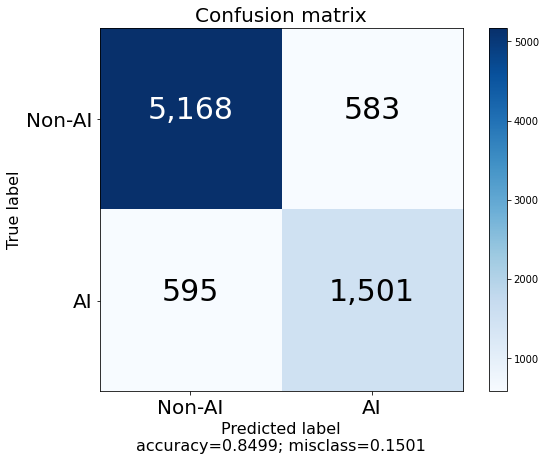

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0,fontsize=20)
        plt.yticks(tick_marks, target_names,fontsize=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",fontsize=30,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",fontsize=30,
                     color="white" if cm[i, j] > thresh else "black" )


    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=16)
    plt.show()

def plot(neglabel,poslabel,preds,labels):
  """
  input : neglabel - false label
          poslabel - true label 
          y_true - true y_labels 
          y_pred - predicted y_labels
  plots : confusion matrix for the y_true and y_pred that is being passed 
  """
  y_pred = np.argmax(preds, axis=1).flatten()
  y_true = labels.flatten()
  # Classification Report
  print(Report(y_true,y_pred))
  # Label Names
  target_names = [neglabel,poslabel]
  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  # Actual Plot (Downloadble)
  plot_confusion_matrix(cm, target_names)

plot("Non-AI","AI",test_pred, test_true_vals)

In [ ]:
# save the test true labels and test predictions 
np.save("AI_test_pred",test_pred)
np.save("AI_test_true_labels",test_true_vals)